<span style='font-size:large'>**Problem Set 3 \(Group Activity\)**</span>

**Leader:** 

**Manansala, Richard M.**

**Members:**

**Dalugdugan, Nicko R.**

**Hilario, Franniel Luigi C.**

**Magbanua, Brian Gabriel G.**

**Pasamba, Jermaine C.**

**Ventura, Fiona C.**



In [4]:
import itertools
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# For reproducibility
test_seed = 42
random.seed(test_seed)
np.random.seed(test_seed)

# Generate 10 random city coordinates within a 100x100 grid
NUM_CITIES = 10
cities = {f"C{i}": (random.uniform(0, 100), random.uniform(0, 100)) for i in range(NUM_CITIES)}

# Distance function
def distance(p, q):
    return math.hypot(p[0] - q[0], p[1] - q[1])

# Precompute distance matrix
distances = {u: {v: distance(cities[u], cities[v]) for v in cities} for u in cities}

def tour_length(path):
    return sum(distances[path[i]][path[(i+1) % len(path)]] for i in range(len(path)))

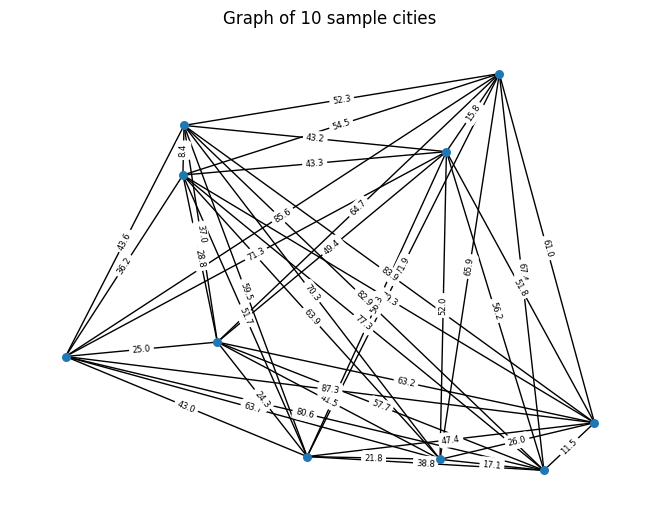

In [5]:
G = nx.Graph()
G.add_nodes_from(cities)
for u,v in itertools.combinations(cities,2):
    G.add_edge(u,v, weight=round(distances[u][v],1))
pos = {c: cities[c] for c in cities}

nx.draw(G, pos, with_labels=False, node_size=30)
edgelabels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgelabels,font_size=6)
plt.title('Graph of 10 sample cities')
plt.axis('off'); plt.show()

In [6]:
start = time.time()
best_length = float('inf')
best_path = None
for perm in itertools.permutations(cities):
    length = sum(distances[perm[i]][perm[(i+1)%len(cities)]] for i in range(len(cities)))
    if length < best_length:
        best_length = length
        best_path = perm
brute_time = time.time() - start
print(f"Brute Force → Length: {best_length:.2f}, Time: {brute_time:.4f}s")

Brute Force → Length: 264.14, Time: 4.6138s


## Nearest Neighbor


1. Initialize a visited list
2. Select a starting city (first in the code) and add to visited
3. Select the next closest unvisited  city and add to visited
4. Repeat step 3 until all cities are visited
5. Return the tour

In [7]:

def nearest_neighbor(G : nx.Graph) -> tuple[list[str], float]:
    n = NUM_CITIES
    first = list(G.nodes)[0]

    #initialize route at the first node
    route = [first] 
    visited = {first}
    best_distance = 0
    while len(visited) < n: 
        current_node = route[-1]
        #Finds the nearest node to the current node that has not been visited yet
        nearest_node, distance = min([(i, distances[current_node][i]) for i in G[current_node] if i not in visited], key=lambda x: x[1])

        route.append(nearest_node)
        visited.add(nearest_node)
        best_distance += distance
    else:
        #Connect last node distance to the first node distance
        best_distance += distances[current_node][first]
    return (route, best_distance)

start = time.time()
nn_path, nn_length = nearest_neighbor(G)
nn_time = time.time() - start
print(f"Nearest Neighbor Time: {(nn_time * 1000):.4f}ms | Best Distance: {nn_length} Path: {nn_path}")

Nearest Neighbor Time: 0.0789ms | Best Distance: 280.7779366357131 Path: ['C0', 'C9', 'C3', 'C4', 'C1', 'C6', 'C5', 'C8', 'C7', 'C2']


## Genetic Algorithm

1. Generate random population from the list of cities
2. Create a new population
   - Select two random parent from population *(tournament selection)*
   - Perform crossover *(Ordered Crossover)* to get an offspring
   - Perform mutation based on probability
   - Add offspring to new population
3. Record the best tour of each new population and compare to the best
4. Repeat step 2-3 until max generations
5. Return the best recorded tour

*References*
[Crossover Methods](https://mat.uab.cat/~alseda/MasterOpt/GeneticOperations.pdf)





In [8]:
import networkx as nx
import random 
from functools import cache



def genetic_alg(G: nx.Graph, pop_size: int, mutation_rate: float, generations: int) -> tuple[list, float]:
    # Initialize a random population
    nodes = list(G.nodes)
    
    def random_population(nodes: list, size: int):
        return [tuple(random.sample(nodes, len(nodes))) for _ in range(size)]

    def crossover(parent1: list, parent2: list):
        # Uses OX crossover method
        size = len(nodes)
        start, end = sorted(random.sample(range(size), 2))
        
        child  = [None] * size
        # Step 1: Copy a substring from parent1
        child[start:end] = parent1[start:end]

        # Step 2: Fill remaining from parent2
        p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while parent2[p2_idx] in child:
                    p2_idx += 1
                child[i] = parent2[p2_idx]
        return tuple(child)
    
    def mutate(route : tuple):
        route = list(route)[:]
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(nodes)), 2)
            route[i], route[j] = route[j], route[i]
        return tuple(route)
    
    def get_parents(population: list[tuple], fitness: list[float]) -> tuple[tuple,tuple]:
        # Tournament selection for parent
        # Selects the top 2 among random 6 individuals.
        candidates = random.choices(list(zip(population, fitness)), k=6)
        candidates.sort(key=lambda x: x[1], reverse=True)
        return (candidates[0][0], candidates[1][0])
    @cache
    def get_length(tour: tuple) -> float:
        return tour_length(tour)
    @cache
    def fitness(tour : tuple) -> float:
        return 1 / get_length(tour)

    population = random_population(nodes, pop_size)
    pop_fitness = [fitness(x) for x in population]
    best_distance = float('Inf')
    best_tour: tuple = None

    for gen in range(generations):
        new_population: list[list] = []
        for _ in range(pop_size):
            p1, p2 = get_parents(population, pop_fitness)
            child = crossover(p1, p2)
            child = mutate(child)
            new_population.append(child)
        population = new_population
        pop_fitness = [fitness(x) for x in new_population]

        current_best_tour = min(list(zip(population, pop_fitness)), key=lambda r: r[1])[0]
        current_best_distance = get_length(current_best_tour)
        if current_best_distance < best_distance:
            best_distance = current_best_distance
            best_tour = current_best_tour
    
    return best_tour, best_distance

POP_SIZE = 100
GENERATIONS = 1000
MUTATION_RATE = 0.01
start = time.time()
tour, ga_length = genetic_alg(G, POP_SIZE, MUTATION_RATE, GENERATIONS)
ga_time = time.time() - start
print(f"Time: {ga_time}, Distance: {ga_length}")

Time: 0.8668637275695801, Distance: 264.13887564142317


## Simulated Annealing (feel free to replace)


1. Select a random tour and calculate its distance
2. Repeat the following til max iterations:
    - Select a neighbor of the current tour (2-opt, swap two random cities in the tour)
      - if new neighbor has less distance than current tour, make it the current tour
      - if new neighbor has greater distance, calculate a probability based on temperature that it will be selected as the current tour
    - Lower temperature by alpha
3. Return the recorded best tour

In [ ]:
T, ALPHA, ITER = 10000, 0.995, 20000


## Ant Colony Optimization


1. Initialize an nxn pheromone matrix with values 1
2. Repeat until max epochs:
    - For each ants:
      - Select a random starting city
      - Calculate the probabilities of the next city to visit based on pheromone matrix, alpha, beta
      - Select the next city based on weighted probability
      - Record as the best tour if its the least distance
      - Repeat until all cities are visited
    - Reduce the pheromones by rho (1 - rho)
    - Deposit pheromones on each calculated tours based on q and distance of tour
3. Return the best recorded tour


In [ ]:
ANTS, EPOCHS, ALPHA, BETA, RHO, Q = 50, 200, 1.0, 5.0, 0.1, 100

Algorithm            |   Distance |  Time(s)
---------------------------------------------
Brute Force          |     264.14 |   4.6138
Nearest Neighbor     |     280.78 |   0.0001
Genetic Algorithm    |     264.14 |   0.8669


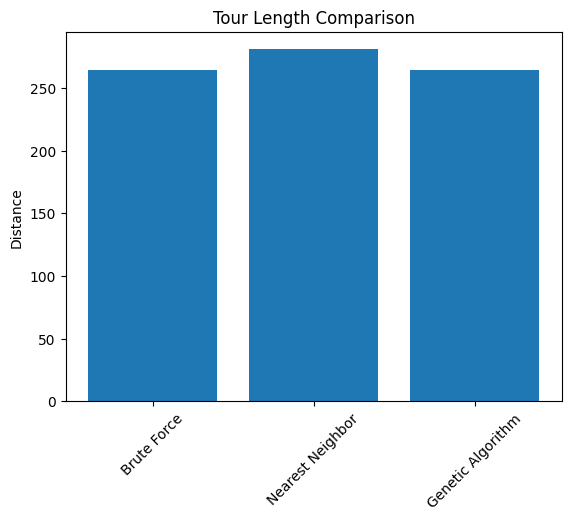

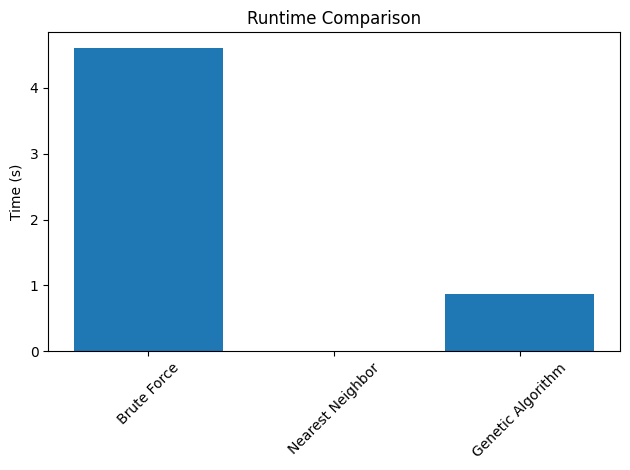

In [10]:
results = [
    ('Brute Force', best_length, brute_time),
    ('Nearest Neighbor', nn_length, nn_time),
    ('Genetic Algorithm', ga_length, ga_time),
    # ('Simulated Annealing', best_e, sa_time),
    # ('Ant Colony', best_len, aco_time)
]

# Table
print(f"{'Algorithm':20s} | {'Distance':>10s} | {'Time(s)':>8s}")
print('-'*45)
for name, dist, t in results:
    print(f"{name:20s} | {dist:10.2f} | {t:8.4f}")

# Charts
labels = [r[0] for r in results]
distances_cmp = [r[1] for r in results]
times_cmp = [r[2] for r in results]

plt.figure()
plt.bar(labels, distances_cmp)
plt.title('Tour Length Comparison')
plt.ylabel('Distance')
plt.xticks(rotation=45)

plt.figure()
plt.bar(labels, times_cmp)
plt.title('Runtime Comparison')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()